In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Introduction

# Getting The Data

To begin this analysis we get data about Beirut explosion from [OML Consolidated Public Sheet](https://docs.google.com/spreadsheets/d/1V1NLhlyBFgrMBz57mrYt65YXmiO3Lt7tOhZwYz2Y8Eo/edit#gid=479015731) and will be using data from **Frontline Engineers** as first for explotary data analysis. There is an [interactive map](https://openmaplebanon.org/) showing the damage condition for buildings and the *OML Consolidated Public Sheet* is also available there. To get the position for each building, we can use [Beirut Built Environment Database Base-map](https://aub.maps.arcgis.com/apps/webappviewer/index.html?id=1d3b43104a53450389dfcb79f9e88464).

In [2]:
from ds100_utils import fetch_and_cache

In [3]:
#building_condition = fetch_and_cache("https://docs.google.com/spreadsheets/d/1V1NLhlyBFgrMBz57mrYt65YXmiO3Lt7tOhZwYz2Y8Eo/edit#gid=479015731?accessType=DOWNLOAD",
#                "FrontLineEngineers.csv", force=False)


In [4]:
#print(building_condition, "is",  os.path.getsize(building_condition) / 1e6, "MB")

In [5]:
building_condition = pd.read_csv('FrontLineEngineers.csv', warn_bad_lines=True) 

In [6]:
building_condition.head(4)

,OML UID,Entity / Source,Survey Type,Status,Assignee,Neighborhood,Zone,Building condition,Lat,Long,...,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
0,FE1,Frontline Engineers,Shelter,Unknown,NaN,NaN,NaN,"Moderate Damage, repair needs to be done, No e...",33.891657,35.532464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shelter
1,FE2,Frontline Engineers,Shelter,Unknown,NaN,NaN,NaN,"Moderate Damage, repair needs to be done, No e...",33.891643,35.532471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FE3,Frontline Engineers,Shelter,Unknown,NaN,NaN,NaN,"Moderate Damage, repair needs to be done, No e...",33.891640,35.532470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FE4,Frontline Engineers,Shelter,Unknown,NaN,NaN,NaN,NaN,33.893270,35.533197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("Rows: {}".format(building_condition.shape[0]))
print("Columns: {}".format(building_condition.shape[1]))

Rows: 398
Columns: 64


In [8]:
building_condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 64 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   OML UID                                                398 non-null    object 
 1   Entity / Source                                        398 non-null    object 
 2   Survey Type                                            398 non-null    object 
 3   Status                                                 398 non-null    object 
 4   Assignee                                               0 non-null      float64
 5   Neighborhood                                           0 non-null      float64
 6   Zone                                                   0 non-null      float64
 7   Building condition                                     126 non-null    object 
 8   Lat                                               

In [9]:
building_condition['OML UID'].nunique()

398

In [10]:
building_condition['Building condition'].head(5)

0    Moderate Damage, repair needs to be done, No e...
1    Moderate Damage, repair needs to be done, No e...
2    Moderate Damage, repair needs to be done, No e...
3                                                  NaN
4    Heavy Damage, Evacuation needed repairs should...
Name: Building condition, dtype: object

In [11]:
building_condition['Building Entrance | مدخل البناية'].head(5)

0    Minor | طفيف
1    Minor | طفيف
2    Minor | طفيف
3             NaN
4    Major | كبير
Name: Building Entrance | مدخل البناية, dtype: object

All unnamed columns only have null values and should be deleted. `OML UID` is unique for each building. I didn't understand what the `Address` means. Not sure how to use `Damaged Doors`. Only 126 buildings have the overall building condition written. 
<br><br>
`Building condition` has 4 levels:
1. **No Damage**, No evacuation
2. **Moderate Damage**, repair needs to be done, No evacuation
3. **Heavy Damage**, Evacuation needed repairs should be done as soon as possible 
4. **Major damage**, Evacuation needed for the Building and the Building nearby
<br>

Conditions for each part of the building, such as `Building Entrance` and `Building Door` has 4 levels:
1. **Minor**
2. **Major**
3. **Severe**



# Data Cleaning

### 1. Delete all unnamed columns

In [12]:
# Delete all unnamed columns
df = building_condition.drop([col for col in building_condition.columns if 'Unnamed' in col], axis=1)
print("Rows: {}".format(df.shape[0]))
print("Columns: {}".format(df.shape[1]))

Rows: 398
Columns: 31


### 2. Delete all columns that don't have `Building condition`

In [13]:
df = df[~df['Building condition'].isnull()]
print("Rows: {}".format(df.shape[0]))

Rows: 126


### 3. Change all column names to English only

In [14]:
import re
colname_english = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
colname_english = colname_english.str.replace(' \|  ','')

In [15]:
#rename
df.columns = colname_english
df.columns

Index(['OML UID', 'Entity / Source', 'Survey Type', 'Status', 'Assignee',
       'Neighborhood', 'Zone', 'Building condition', 'Lat', 'Long', 'Address',
       'Building Entrance', 'Building Door Entrance ', 'Water Collection ',
       'Water Pump', 'Water Distribution Tank ', 'Water Main Supply ',
       'Electricity Room', 'Electricity Main Supply ',
       'Sanitation Main Supply  ', 'Sanitation Winter Water',
       'Building Glasses', 'Building HandRail', 'Building Balcony',
       'Building Exterior', 'Building Structure Damage',
       'Building Surface Isolation', 'Building Roof', 'Damaged Doors',
       'Supplier UID', 'Survey Date'],
      dtype='object')

### 4. Map `Building condition` to numerical levels (1-4) and Conditions for each part of the building to numerical levels (1-3)

1: **No Damage**, No evacuation
<br>
2: **Moderate Damage**, repair needs to be done, No evacuation
<br>
3: **Heavy Damage**, Evacuation needed repairs should be done as soon as possible 
<br>
4: **Major damage**, Evacuation needed for the Building and the Building nearby

1: **Minor**
<br>
2: **Major**
<br>
3: **Severe**

In [16]:

bc_mapping = {"No Damage, No evacuation":1, 
              "Moderate Damage, repair needs to be done, No evacuation":2, 
              "Heavy Damage, Evacuation needed repairs should be done as soon as possible ":3, 
              "Major damage, Evacuation needed for the Building and the Building nearby":4}
df['building_condition_num'] = df['Building condition'].map(bc_mapping)

In [17]:
df['Building condition'].value_counts()

Moderate Damage, repair needs to be done, No evacuation                        86
No Damage, No evacuation                                                       29
Heavy Damage, Evacuation needed repairs should be done as soon as possible      6
Major damage, Evacuation needed for the Building and the Building nearby        5
Name: Building condition, dtype: int64

In [18]:
df['building_condition_num'].value_counts()

2    86
1    29
3     6
4     5
Name: building_condition_num, dtype: int64

In [19]:

for col in df.loc[:, 'Building Entrance':'Building Roof']:
    df[col] = (df[col].str.replace('.*Minor.*', '1'))
    df[col] = (df[col].str.replace('.*Major.*', '2'))
    df[col] = (df[col].str.replace('.*Severe.*', '3'))

In [37]:
string_to_int_mapping = {'1':1, '2':2, '3':3}
for col in df.loc[:, 'Building Entrance':'Building Roof']:
    df[col] = df[col].map(string_to_int_mapping)

### 5. Change Survey date to datetime object for easier usage

In [20]:
from datetime import datetime
df["Survey Date"] = pd.to_datetime(df["Survey Date"])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 155
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype                                
---  ------                      --------------  -----                                
 0   OML UID                     126 non-null    object                               
 1   Entity / Source             126 non-null    object                               
 2   Survey Type                 126 non-null    object                               
 3   Status                      126 non-null    object                               
 4   Assignee                    0 non-null      float64                              
 5   Neighborhood                0 non-null      float64                              
 6   Zone                        0 non-null      float64                              
 7   Building condition          126 non-null    object                               
 8   Lat                 

# Explotary Data Analysis

### Number of buildings in different damage conditions

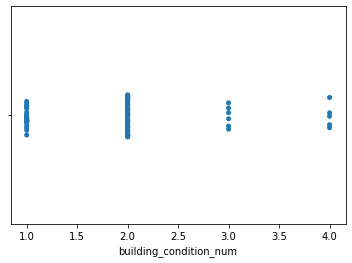

In [22]:
ax = sns.stripplot(x=df['building_condition_num'])

Most buildings are no or maderate damage.

### Plot of relationship between `Building condition` and damage of each part of the building

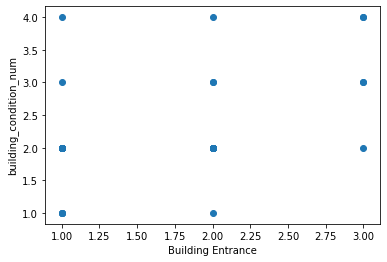

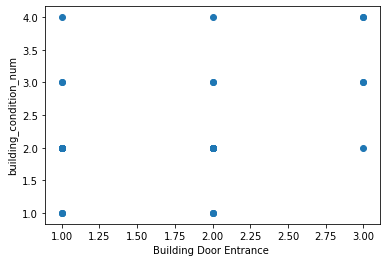

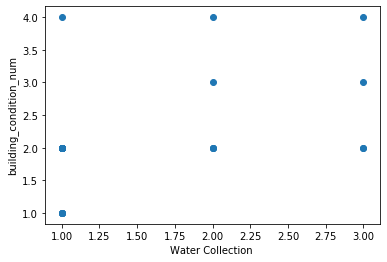

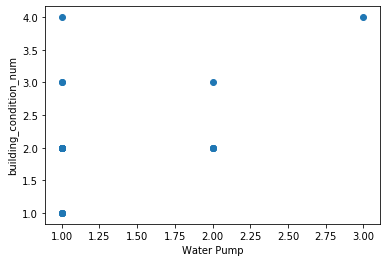

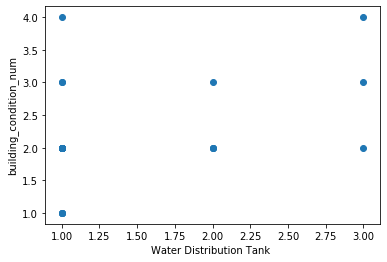

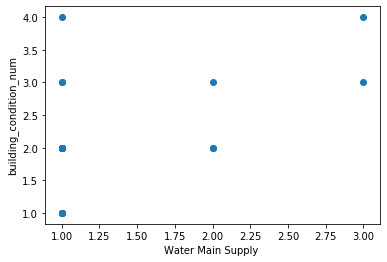

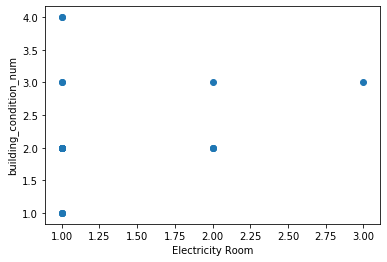

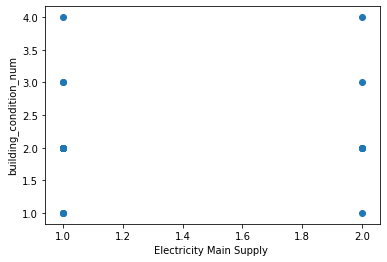

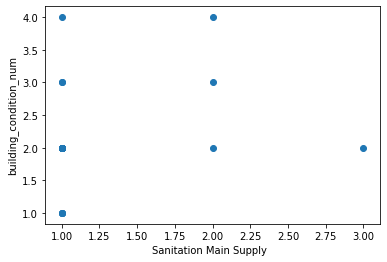

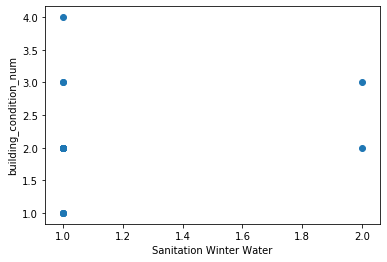

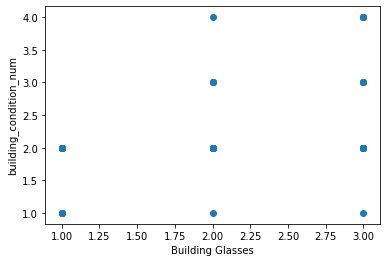

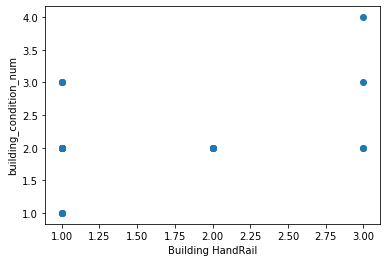

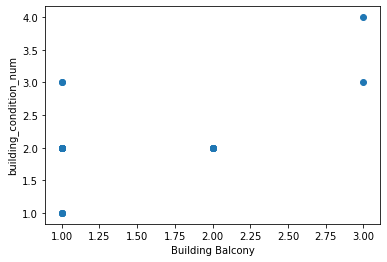

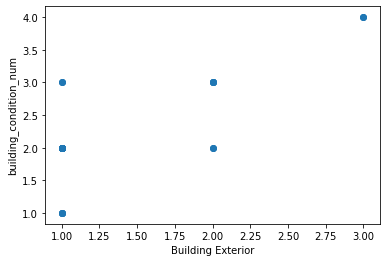

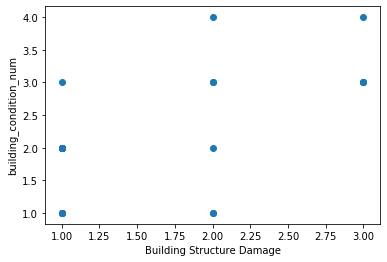

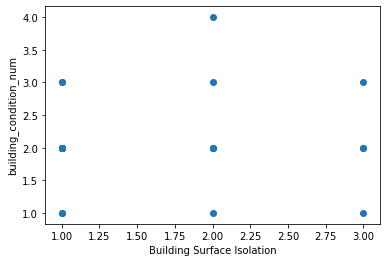

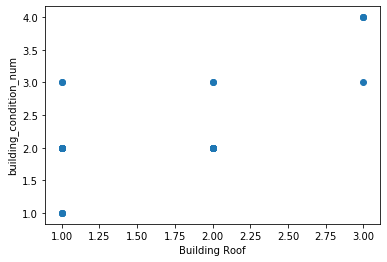

In [38]:
for col in df.loc[:, 'Building Entrance':'Building Roof']:
    plt.figure()
    plt.scatter(x=df[~df[col].isnull()][col],y=df[~df[col].isnull()]['building_condition_num']);
    plt.xlabel(col)
    plt.ylabel('building_condition_num')
    plt.show()

### Plot of relationship between `Building condition` and sum of the damage for each part
(may not reflect the relationship well due to many missing values for the damage for each part)

In [39]:
df['Sum of sub damage'] = 0
for col in df.loc[:, 'Building Entrance':'Building Roof']:
    df['Sum of sub damage'] += df[col]
    

Text(0, 0.5, 'building_condition_num')

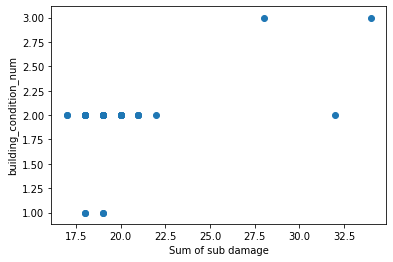

In [42]:
plt.scatter(x=df[~df['Sum of sub damage'].isnull()]['Sum of sub damage'],y=df[~df['Sum of sub damage'].isnull()]['building_condition_num']);
plt.xlabel('Sum of sub damage')
plt.ylabel('building_condition_num')


In [46]:
print("Number of buildings that have all subdamage recorded are: {}".format(len(df['Sum of sub damage'].dropna())))

Number of buildings that have all subdamage recorded are: 39


In [28]:
import folium
import folium.plugins

coords_center = (33.901389, 35.518889)
fl_map = folium.Map(location=coords_center, zoom_start=13)
locs = df[['Lat', 'Long']].astype('float').dropna().values
heatmap = folium.plugins.HeatMap(locs.tolist(), radius=10)
fl_map.add_child(heatmap)

### Map of different building damage level with coordinate

1: No Damage, No evacuation

In [49]:
locations = df[df['building_condition_num'] == 1][['Lat', 'Long']]

cluster = folium.plugins.MarkerCluster()
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Long"])]))
    
one_map = folium.Map(location=coords_center, zoom_start=13)
one_map.add_child(cluster)
one_map

2: Moderate Damage, repair needs to be done, No evacuation


In [50]:
locations = df[df['building_condition_num'] == 2][['Lat', 'Long']]

cluster = folium.plugins.MarkerCluster()
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Long"])]))
    
one_map = folium.Map(location=coords_center, zoom_start=13)
one_map.add_child(cluster)
one_map

3: Heavy Damage, Evacuation needed repairs should be done as soon as possible

In [51]:
locations = df[df['building_condition_num'] == 3][['Lat', 'Long']]

cluster = folium.plugins.MarkerCluster()
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Long"])]))
    
one_map = folium.Map(location=coords_center, zoom_start=13)
one_map.add_child(cluster)
one_map

4: Major damage, Evacuation needed for the Building and the Building nearby

In [52]:
locations = df[df['building_condition_num'] == 4][['Lat', 'Long']]

cluster = folium.plugins.MarkerCluster()
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Long"])]))
    
one_map = folium.Map(location=coords_center, zoom_start=13)
one_map.add_child(cluster)
one_map

Generally speaking, damage level further away from the explosion center are lower.

### Add feature `distance` measuring the distance from a perticular building to explosion center 
Explosion center: (latitude 33.901389, longitude 35.518889) from [GeoHack - 2020 Beirut explosion](https://geohack.toolforge.org/geohack.php?pagename=2020_Beirut_explosion&params=33_54_05_N_35_31_08_E_region:lb_type:event)

In [ ]:
import math
# Get distance in km
def get_distance(lat_1, lng_1, lat_2, lng_2): 
    lng_1, lat_1, lng_2, lat_2 = map(math.radians, [lng_1, lat_1, lng_2, lat_2])
    d_lat = lat_2 - lat_1
    d_lng = lng_2 - lng_1 

    temp = (  
         math.sin(d_lat / 2) ** 2 
       + math.cos(lat_1) 
       * math.cos(lat_2) 
       * math.sin(d_lng / 2) ** 2
    )

    return 6373.0 * (2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp)))


In [ ]:
# Code calculating distance using coordinates accroding to Haversine formula, which assumes the earth is a sphere
import geopy.distance

coords_center = (33.901389, 35.518889)
# df with known Lat and Long
df2 = df[df['Lat'] > 0]
coords_buildings = df2[['Lat', 'Long']]
coords_buildings = list(coords_buildings.itertuples(index=False, name=None))
df2['distance'] = 0
for i in range(len(coords_buildings)):
    # Hard coded to avoid NaN
#     if coords_buildings[i][0] > 0 :
#     df2['distance'][i] = geopy.distance.distance(coords_center, coor).km
    df2['distance'][i] = get_distance(coords_center[0], coords_center[1], coords_buildings[i][0], coords_buildings[i][1])
#     else:
#         df['distance'][i] = coords_buildings[i][0]
        



In [ ]:
df['Lat'].head(20)

In [ ]:
print(len(df2['distance']), len(df2['Lat']))
df2['distance'].head(20)

In [ ]:
df2[['Lat', "Long", 'distance']]
df2.shape

### Relationship betwen distance to explosion center to damage level

In [ ]:
plt.scatter(x=df['distance'], y=df['building_condition_num']);

# Principle Component Analysis

# Machine Learning